In [ ]:
import numpy as np
import pandas as pd
import pennylane as qml

from susy_qm import calculate_Hamiltonian
from susy_qm import calculate_wz_hamiltonian

from qutip import Qobj, ptrace, entropy_vn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [42]:
psi = np.array([1/2, 1/2, 1/2, 1/2])
psi = np.array([1/np.sqrt(2), 0, 0, 1/np.sqrt(2)])

psi_q = Qobj(psi, dims=[[2, 2], [1, 1]])
rho = psi_q * psi_q.dag()
p_rho = ptrace(rho, 0)
  
entropy = entropy_vn(p_rho, base=2)
entropy

np.float64(1.0)

In [60]:
cutoff_list = [2,4,8,16,32,64]
potential_list = ['QHO', 'DW', 'AHO']

d_potentials = []
d_cutoff = []
d_entropies = []

for potential in potential_list:
    for cutoff in cutoff_list:

        H = calculate_Hamiltonian(cutoff, potential)
        num_qubits = int(np.log2(cutoff) + 1)

        eigenvalues, eigenvectors = np.linalg.eig(H)
        min_index = np.argmin(eigenvalues)
        min_eigenvalue = eigenvalues[min_index]
        min_eigenvector = np.asarray(eigenvectors[:, min_index])

        min_3_ev = eigenvalues.argsort()[:3]

        entropies = []

        for e_lev in range(3):
            eig_vec = np.asarray(eigenvectors[:, min_3_ev[e_lev]])
            psi = Qobj(eig_vec, dims=[[2]*num_qubits, [1]*num_qubits])

            rho = psi * psi.dag()
            p_rho = ptrace(rho, num_qubits-1)
            entropy = entropy_vn(p_rho, base=2)
            entropies.append(entropy)
            #print("Entanglement entropy:", entropy)

        d_potentials.append(potential)
        d_cutoff.append(cutoff)
        d_entropies.append(entropies)


In [61]:
data = {'potential': d_potentials,
        'cutoff': d_cutoff,
        'entropies': d_entropies}

df = pd.DataFrame(data)
df[['e1', 'e2', 'e3']] = pd.DataFrame(df['entropies'].tolist(), index=df.index)
df

,potential,cutoff,entropies,e1,e2,e3
0,QHO,2,"[5.647277761308516e-16, 5.647277761308516e-16,...",5.647278e-16,5.647278e-16,5.647278e-16
1,QHO,4,"[5.647277761308516e-16, 5.647277761308516e-16,...",5.647278e-16,5.647278e-16,5.647278e-16
2,QHO,8,"[5.647277761308516e-16, 5.647277761308516e-16,...",5.647278e-16,5.647278e-16,5.647278e-16
3,QHO,16,"[5.647277761308516e-16, 5.647277761308516e-16,...",5.647278e-16,5.647278e-16,5.647278e-16
4,QHO,32,"[5.647277761308516e-16, 5.647277761308516e-16,...",5.647278e-16,5.647278e-16,5.647278e-16
5,QHO,64,"[5.647277761308516e-16, 5.647277761308516e-16,...",5.647278e-16,5.647278e-16,5.647278e-16
6,DW,2,"[8.850704265123434e-16, 5.647277761308516e-16,...",8.850704e-16,5.647278e-16,3.317945e-15
7,DW,4,"[0.008346567449149212, 0.13589156196494429, 0....",8.346567e-03,1.358916e-01,3.133106e-01
8,DW,8,"[0.1701145956499725, 0.012932042870270352, 0.5...",1.701146e-01,1.293204e-02,5.005988e-01
9,DW,16,"[0.16321323317494407, 0.003655728261703918, 0....",1.632132e-01,3.655728e-03,8.220363e-01


In [43]:
potential = 'DW'
cutoffs = [2, 4, 8, 16, 32, 64, 128, 256]

# 9 qubits for 256
data = {}
data_qu = int(np.log2(max(cutoffs))) + 1
for qubit in range(data_qu):
        data[f"q{qubit}"] = []


for cutoff in cutoffs:

    print(f"Running for cutoff: {cutoff}")

    #calculate Hamiltonian and expected eigenvalues
    H = calculate_Hamiltonian(cutoff, potential)

    eigenvalues, eigenvectors = np.linalg.eig(H)
    min_index = np.argmin(eigenvalues)
    min_eigenvalue = eigenvalues[min_index]
    min_eigenvector = np.asarray(eigenvectors[:, min_index])

    num_qubits = int(np.log2(cutoff) + 1)

    psi = Qobj(min_eigenvector, dims=[[2]*num_qubits, [1]*num_qubits])
    rho = psi * psi.dag()

    cutoff_qubits = []
    for qubit in range(num_qubits):
       
        rho_q = ptrace(rho, [qubit])
        entropy = entropy_vn(rho_q, base=2)

        col_name = f"q{qubit}"
        data[col_name].append(entropy)

        cutoff_qubits.append(col_name)

    nan_qubits = list(set(data.keys()) - set(cutoff_qubits))
    for key in nan_qubits:
        data[key].append(np.nan)

data['cutoffs'] = cutoffs.copy()
#data           

Running for cutoff: 2
Running for cutoff: 4
Running for cutoff: 8
Running for cutoff: 16
Running for cutoff: 32
Running for cutoff: 64
Running for cutoff: 128
Running for cutoff: 256


In [44]:
pd.DataFrame(data)

,q0,q1,q2,q3,q4,q5,q6,q7,q8,cutoffs
0,8.850704e-16,8.850704e-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1,2.443851e-16,8.346567e-03,8.346567e-03,NaN,NaN,NaN,NaN,NaN,NaN,4
2,8.850704e-16,4.115830e-02,1.812110e-01,1.701146e-01,NaN,NaN,NaN,NaN,NaN,8
3,5.647278e-16,1.925077e-03,2.057769e-02,1.621727e-01,0.163213,NaN,NaN,NaN,NaN,16
4,2.443851e-16,8.649974e-06,1.774160e-03,2.040281e-02,0.162042,0.163131,NaN,NaN,NaN,32
5,1.045242e-15,6.193965e-10,8.633680e-06,1.774146e-03,0.020403,0.162042,0.163131,NaN,NaN,64
6,7.248991e-16,7.248991e-16,3.237421e-10,1.304201e-06,0.000838,0.002423,0.001790,0.003655,NaN,128
7,1.045242e-15,1.045242e-15,1.045242e-15,3.237425e-10,0.000001,0.000838,0.002423,0.001790,0.003655,256


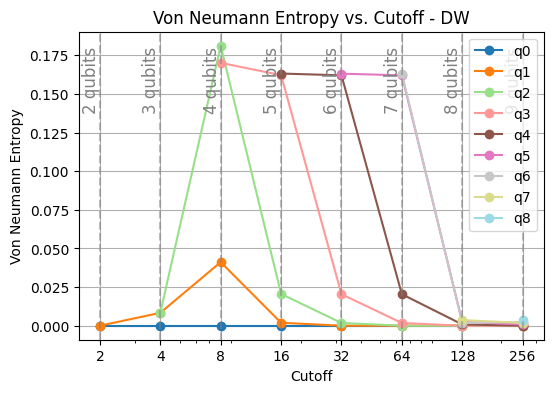

In [45]:
num_pairs = len(data.keys()) - 1
cmap = plt.get_cmap('tab20')
colours = [cmap(i) for i in np.linspace(0, 1, num_pairs)]

#plt.figure(figsize=(25,10))
plt.figure(figsize=(6,4))
for colour, key in zip(colours, data.keys()):
    if key != "cutoffs":
       
        final_value = data[key][-1]
        label = f"{key}"# ({final_value:.6f})"
        plt.plot(data["cutoffs"], data[key], marker='o', color=colour, label=label)

for cutoff in data['cutoffs']:
    plt.axvline(x=cutoff, linestyle='--', color='grey', alpha=0.5)
    ymax = plt.ylim()[1]
    
    num_qubits = int(np.log2(cutoff)) + 1
    plt.text(cutoff, ymax * 0.95, f"{num_qubits} qubits",
             rotation=90, verticalalignment='top', horizontalalignment='right',
             color='grey', fontsize=12)

plt.xlabel("Cutoff")
plt.xticks(data["cutoffs"])
plt.xscale("log")


ax = plt.gca()
ax.set_xticks(cutoffs)
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
plt.xticks(data["cutoffs"], labels=cutoffs)

plt.ylabel("Von Neumann Entropy")
plt.title(f"Von Neumann Entropy vs. Cutoff - {potential}")
plt.legend()
plt.grid()
#plt.show()
plt.savefig(r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\SUSY QM\Entanglement\VonNeumannPlots\small_plot_{}".format(potential))

# Wess - Zumino

In [12]:
a = 1.0
sites = [2,3]
potential_list = ['linear', 'quadratic']
bc_list = ['periodic', 'dirichlet']
cutoff_list = [2,4]

d_bcs = []
d_potentials = []
d_sites = []
d_cutoff = []
d_entropies = []

for boundary_condition in bc_list:
    for potential in potential_list:
        for N in sites:
            for cutoff in cutoff_list:

                if potential == 'linear':
                    c=0
                else:
                    c=-0.8
                print(cutoff, N, a, potential, boundary_condition, c)
                H = calculate_wz_hamiltonian(cutoff, N, a, potential, boundary_condition, c)
                eigenvalues, eigenvectors = np.linalg.eig(H)
                min_index = np.argmin(eigenvalues)
                min_eigenvalue = eigenvalues[min_index]
                min_eigenvector = np.asarray(eigenvectors[:, min_index])

                min_3_ev = eigenvalues.argsort()[:3]

                entropies = []

                for e_lev in range(3):
                    eig_vec = np.asarray(eigenvectors[:, min_3_ev[e_lev]])
                    mat = eig_vec.reshape([2,cutoff]*N)

                    u, s, vh = np.linalg.svd(mat, full_matrices=False)
                    p = s**2

                    p = p / np.sum(p)

                    entropy = -np.sum(p[p > 0] * np.log2(p[p > 0]))
                    #print("Entanglement entropy:", entropy)
                    entropies.append(entropy)

                d_bcs.append(boundary_condition)
                d_potentials.append(potential)
                d_sites.append(N)
                d_cutoff.append(cutoff)
                d_entropies.append(entropies)

2 2 1.0 linear periodic 0
4 2 1.0 linear periodic 0
2 3 1.0 linear periodic 0
4 3 1.0 linear periodic 0
2 2 1.0 quadratic periodic -0.8
4 2 1.0 quadratic periodic -0.8
2 3 1.0 quadratic periodic -0.8
4 3 1.0 quadratic periodic -0.8
2 2 1.0 linear dirichlet 0
4 2 1.0 linear dirichlet 0
2 3 1.0 linear dirichlet 0
4 3 1.0 linear dirichlet 0
2 2 1.0 quadratic dirichlet -0.8
4 2 1.0 quadratic dirichlet -0.8
2 3 1.0 quadratic dirichlet -0.8
4 3 1.0 quadratic dirichlet -0.8


In [14]:
data = {'boundary_condition': d_bcs,
        'potential': d_potentials,
        'sites': d_sites,
        'cutoff': d_cutoff,
        'entropies': d_entropies}

df = pd.DataFrame(data)
df[['e1', 'e2', 'e3']] = pd.DataFrame(df['entropies'].tolist(), index=df.index)

In [15]:
df

,boundary_condition,potential,sites,cutoff,entropies,e1,e2,e3
0,periodic,linear,2,2,"[-0.0, -0.0, -0.0]",-0.000000e+00,-0.000000e+00,-0.000000e+00
1,periodic,linear,2,4,"[1.2024318819340826e-30, 2.1931380874042616e-2...",1.202432e-30,2.193138e-28,4.460943e-30
2,periodic,linear,3,2,"[2.7103871772509045, 2.710387177250904, 2.4560...",2.710387e+00,2.710387e+00,2.456034e+00
3,periodic,linear,3,4,"[0.5590080945457092, 1.1971900597256897, 2.981...",5.590081e-01,1.197190e+00,2.981627e+00
4,periodic,quadratic,2,2,"[2.0, 2.0053359415580108, 2.08326203729745]",2.000000e+00,2.005336e+00,2.083262e+00
5,periodic,quadratic,2,4,"[1.6437761230259733, 1.7815863374539782, 1.615...",1.643776e+00,1.781586e+00,1.615653e+00
6,periodic,quadratic,3,2,"[3.5315784240908865, 3.5292636683183494, 4.057...",3.531578e+00,3.529264e+00,4.057390e+00
7,periodic,quadratic,3,4,"[5.590174196349956, 5.584215791039318, 5.00571...",5.590174e+00,5.584216e+00,5.005714e+00
8,dirichlet,linear,2,2,"[0.2981175133945634, 0.2981175133945634, 0.298...",2.981175e-01,2.981175e-01,2.981175e-01
9,dirichlet,linear,2,4,"[0.0331432326523854, 1.01692749232054, 1.01659...",3.314323e-02,1.016927e+00,1.016598e+00


In [ ]:
a = 1.0
sites = [3]
potential_list = ['quadratic']#'linear', ]
bc_list = ['periodic']#, 'dirichlet']
cutoffs = [2,4,8,16]

for boundary_condition in bc_list:
    for potential in potential_list:
        for N in sites:

            d_num_qubits = int(N * (np.log2(max(cutoffs))+1))
            data = {}
            for qubit in range(d_num_qubits):
                    data[f"q{qubit}"] = []

            for cutoff in cutoffs:

                if potential == 'linear':
                    c_list = [0]
                else:
                    c_list = [-0.8]
                    
                for c in c_list:

                    print(cutoff, N, a, potential, boundary_condition, c)
                    H = calculate_wz_hamiltonian(cutoff, N, a, potential, boundary_condition, c)
                    eigenvalues, eigenvectors = np.linalg.eig(H)
                    min_index = np.argmin(eigenvalues)
                    min_eigenvalue = eigenvalues[min_index]
                    min_eigenvector = np.asarray(eigenvectors[:, min_index])
                    num_qubits = int(np.log2(len(min_eigenvector)))
                    
                    psi = Qobj(min_eigenvector, dims=[[2]*num_qubits, [1]*num_qubits])
                    rho = psi * psi.dag()

                    cutoff_qubits = []
                    for qubit in range(num_qubits):
                    
                        rho_q = ptrace(rho, [qubit])
                        entropy = entropy_vn(rho_q, base=2)

                        col_name = f"q{qubit}"
                        data[col_name].append(entropy)

                        cutoff_qubits.append(col_name)

                    nan_qubits = list(set(data.keys()) - set(cutoff_qubits))
                    for key in nan_qubits:
                        data[key].append(np.nan)

                    data['cutoffs'] = cutoffs.copy()

            
            #break
        #break
    #break

                

2 3 1.0 quadratic periodic -0.8
4 3 1.0 quadratic periodic -0.8
8 3 1.0 quadratic periodic -0.8
16 3 1.0 quadratic periodic -0.8


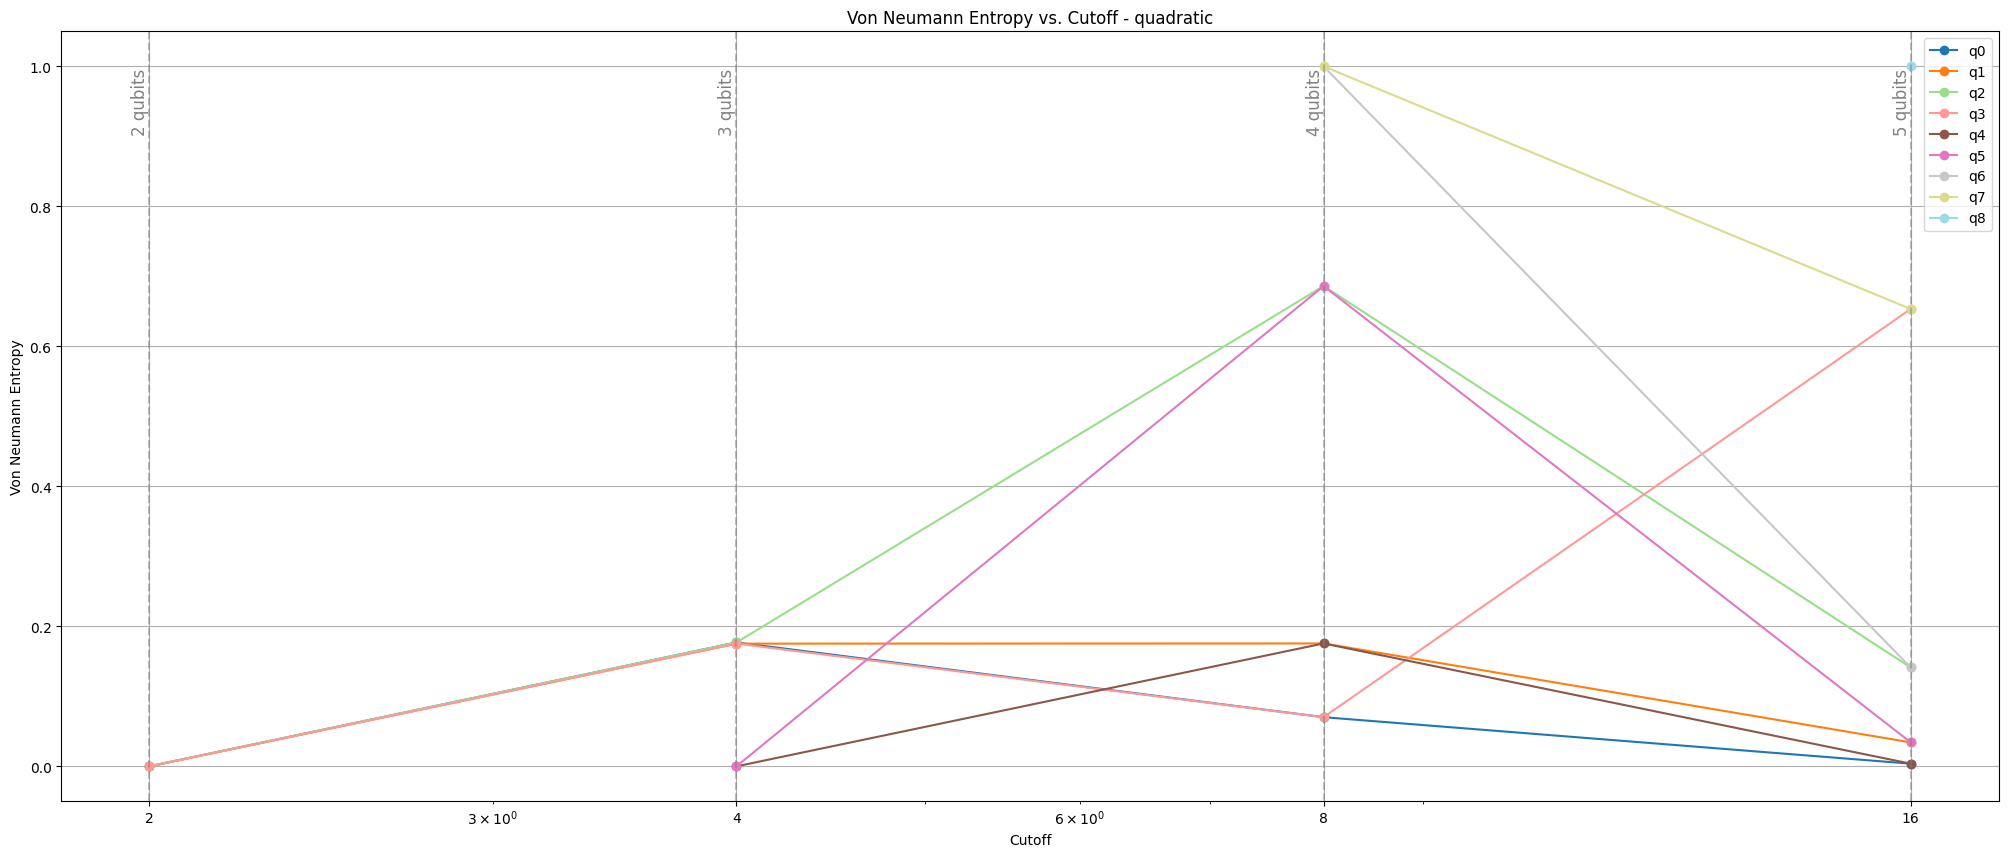

In [84]:
datnum_pairs = len(data.keys()) - 1
cmap = plt.get_cmap('tab20')
colours = [cmap(i) for i in np.linspace(0, 1, num_pairs)]

plt.figure(figsize=(25,10))
#plt.figure(figsize=(6,4))
for colour, key in zip(colours, data.keys()):
    if key != "cutoffs":
       
        final_value = data[key][-1]
        label = f"{key}"# ({final_value:.6f})"
        plt.plot(data["cutoffs"], data[key], marker='o', color=colour, label=label)

for cutoff in data['cutoffs']:
    plt.axvline(x=cutoff, linestyle='--', color='grey', alpha=0.5)
    ymax = plt.ylim()[1]
    
    num_qubits = int(np.log2(cutoff)) + 1
    plt.text(cutoff, ymax * 0.95, f"{num_qubits} qubits",
             rotation=90, verticalalignment='top', horizontalalignment='right',
             color='grey', fontsize=12)

plt.xlabel("Cutoff")
plt.xticks(data["cutoffs"])
plt.xscale("log")


ax = plt.gca()
ax.set_xticks(cutoffs)
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
plt.xticks(data["cutoffs"], labels=cutoffs)

plt.ylabel("Von Neumann Entropy")
plt.title(f"Von Neumann Entropy vs. Cutoff - {potential}")
plt.legend()
plt.grid()
plt.show()
#plt.savefig(r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\SUSY QM\Entanglement\VonNeumannPlots\small_plot_{}".format(potential))